In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [44]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [5]:
root_dir = '/media/akumar/Data/nse/'

In [6]:
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)

In [7]:
from plotting_utils import *
import h5py

In [8]:
sparsity = np.unique(lasso['sparsity'].values)

In [74]:
def calc_eta_sa(cov_indices, df, flag, threshold=1):
    t0 = time.time()
    eta = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):

        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        
        # Calculate the alpha associated with this unique combination of model parameters
        sigma, cov_param = load_covariance(cov_idx)
        rho = 1/bound_eigenvalue(np.linalg.inv(sigma), int(df_.iloc[0]['sparsity'] * df_.iloc[0]['n_features']))            

        # take the minimum non-zero beta value
        beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 
                         1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')        
        
        # Sparsify beta
        beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'],
                             seed = cov_param['block_size'])

        beta = beta.ravel()
        
        k = np.nonzero(beta)[0]

        if len(k) > 0 and len(k) < beta.size:            
            eta[i] = calc_irrep_const(sigma, k)
        else:
            eta[i] = np.nan

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_['sa'].values > threshold)/len(cov_indices[i])
    
    return eta, sa

In [52]:
# Eigenvalue constant
def calc_alpha_sa(cov_indices, df, flag, threshold=1):
    t0 = time.time()
    alphas = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):

        df_ = apply_df_filters(df, cov_idx=cov_idx)

        # Calculate the alpha associated with this unique combination of model parameters
        sigma, cov_param = load_covariance(cov_idx)
        rho = 1/bound_eigenvalue(np.linalg.inv(sigma), int(df_.iloc[0]['sparsity'] * df_.iloc[0]['n_features']))            

        # take the minimum non-zero beta value
        beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 
                         1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')        
        
        # Sparsify beta
        beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'],
                             seed = cov_param['block_size'])

        beta=beta.ravel()
        
        # generate the data under the assumption that the SNR will be very similar across reps
        _, _, _, _, ss = gen_data(df_.iloc[0]['n_samples'], df_.iloc[0]['n_features'],
                                  df_.iloc[0]['kappa'], sigma, beta, 
                                  seed=df_.iloc[0]['seed'])

        alphas[i] = np.mean(rho * np.min(np.abs(beta[np.nonzero(beta)[0]]))/ss)

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)

        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_.iloc[cov_indices[i]]['sa'].values > threshold)/len(cov_indices[i])
           
    return alphas, sa

In [ ]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'CV'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary
alpha = []
sa = []

for i, dframe in enumerate(dframes):        
    alpha.append([])
    sa.append([])
        
    for j, bw in enumerate(betawidth):
        t0 = time.time()
        for k, s in enumerate(sparsity):
            df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=selection_method,
                                  betawidth=bw, sparsity=s)
            
            cov_indices = np.unique(df['cov_idx'].values)
            alpha_, sa_ = calc_alpha_sa(cov_indices, df, flag=None) 

            alpha[i].extend(alpha_)
            sa[i].extend(sa_)
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


Dataframe: UoI, bw_idx: 0, time: 1199.576339
Dataframe: UoI, bw_idx: 1, time: 846.089552
Dataframe: UoI, bw_idx: 2, time: 845.078322
Dataframe: Lasso, bw_idx: 0, time: 1171.323363
Dataframe: Lasso, bw_idx: 1, time: 860.246317
Dataframe: Lasso, bw_idx: 2, time: 904.051251
Dataframe: MCP, bw_idx: 0, time: 1216.564642
Dataframe: MCP, bw_idx: 1, time: 912.488177
Dataframe: MCP, bw_idx: 2, time: 953.303839
Dataframe: SCAD, bw_idx: 0, time: 1245.918597


In [66]:
import pickle

In [67]:
# In case the kernel crashes
with open('alpha_sa_BIC_noUoI', 'wb') as f:
    f.write(pickle.dumps(['Lasso', 'MCP', 'SCAD', 'EN']))
    f.write(pickle.dumps(alpha))
    f.write(pickle.dumps(sa))

In [75]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
kappa = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary
eta = []
sa_eta = []

for i, dframe in enumerate(dframes):
    t0 = time.time()
    eta.append([])
    sa_eta.append([])
        
    for j, bw in enumerate(betawidth):
        for k, s in enumerate(sparsity):
            df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=selection_method,
                                  betawidth=bw, sparsity=s)
            cov_indices = np.unique(df['cov_idx'].values)
            eta_, sa_ = calc_eta_sa(cov_indices, df, flag=None) 
            eta[i].extend(eta_)
            sa_eta[i].extend(sa_)
            
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

/home/akumar/anaconda3/envs/nse/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Dataframe: Lasso, bw_idx: 0, time: 944.877535
Dataframe: Lasso, bw_idx: 1, time: 1564.140131
Dataframe: Lasso, bw_idx: 2, time: 2184.625480
Dataframe: MCP, bw_idx: 0, time: 945.298219
Dataframe: MCP, bw_idx: 1, time: 1568.598998
Dataframe: MCP, bw_idx: 2, time: 2191.347532
Dataframe: SCAD, bw_idx: 0, time: 948.724759
Dataframe: SCAD, bw_idx: 1, time: 1570.271118
Dataframe: SCAD, bw_idx: 2, time: 2191.776856
Dataframe: EN, bw_idx: 0, time: 944.455778
Dataframe: EN, bw_idx: 1, time: 1566.170808
Dataframe: EN, bw_idx: 2, time: 2187.949424


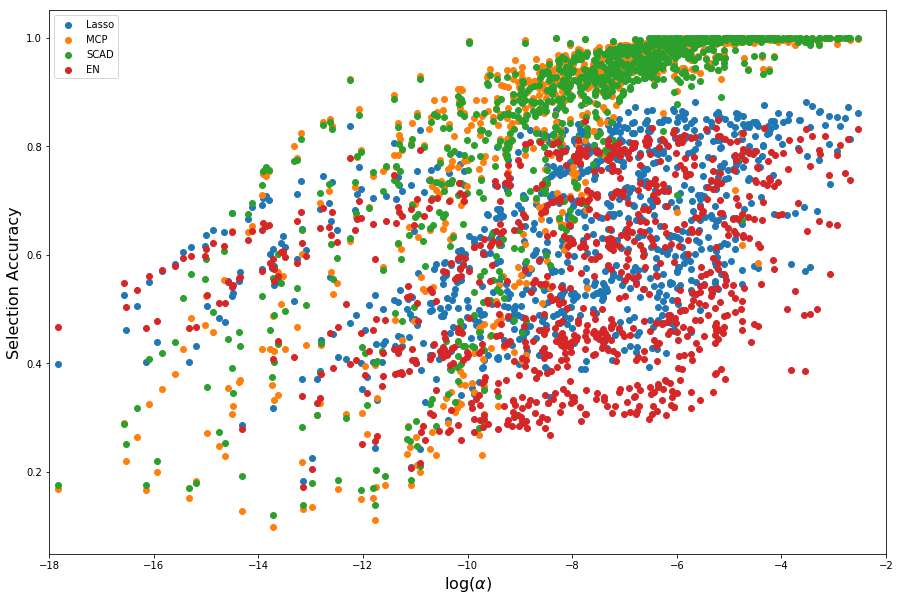

In [55]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
np_ratio = 4
k = 5
betawidth = np.unique(lasso['betawidth'].values)
selection_method = 'BIC'

dframes = [lasso, mcp, scad, en]
#dframes = [uoi, en]
dframe_names = ['Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols


fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframes):        
    ax.scatter(np.ma.log(alpha[i]), sa[i], label=dframe_names[i])
    
ax.set_xlim([-18, -2])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\log(\alpha)$', fontsize=16)
ax.legend()

plt.savefig('n_scaling.pdf', bbox_inches='tight', pad_inches=0)

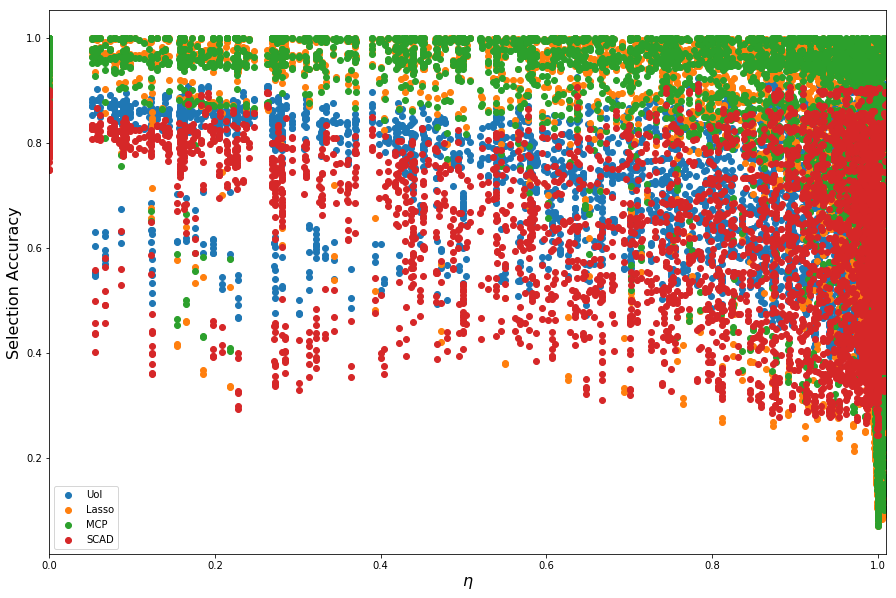

In [76]:
# Now generate an analogous plot for alpha
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']

#dframes = [uoi, en]
dframe_names = ['UoI', 'Lasso', 'MCP', 'SCAD', 'EN']

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], c4[0], c5[0]]
pal_colors = cols

fig, ax = plt.subplots(figsize=(15, 10))

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

for i, dframe in enumerate(dframes):        
    ax.scatter(eta[i], sa_eta[i], label=dframe_names[i])
    
ax.set_xlim([0, 1.01])
ax.set_ylabel('Selection Accuracy', fontsize=16)
ax.set_xlabel(r'$\eta$', fontsize=16)
ax.legend()

plt.savefig('n_scaling_eta.pdf', bbox_inches='tight', pad_inches=0)